In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import os
import shutil
from PIL import Image
import numpy as np
import seaborn as sns
import time

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# CNN

In [3]:
class TennisStrokeCNNClassifier(nn.Module):
    def __init__(self, num_classes=4):
        
        super(TennisStrokeCNNClassifier, self).__init__()
        self.num_classes = num_classes
        
        self.pad1 = nn.ReplicationPad2d(1)
        
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(32 * 7 * 3, 128)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, num_classes)
                
        
    def _num_flatten_features(self, x):
        num_features = 1
        for s in x.size()[1:]:  # Don't use batch size dim
            num_features *= s
        return num_features    
    
    
    def forward(self, x):
        x = self.pad1(x)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool1(self.relu2(self.bn2(self.conv2(x))))
        x = self.dropout1(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        
        x = x.view(-1, self._num_flatten_features(x))
        x = self.relu4(self.fc1(x))
        x = self.dropout2(x)
        x = self.relu5(self.fc2(x))
        x = self.fc3(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x

In [4]:
def compute_dataset_stats(dataset_path, batch_size=64, random_state=42):
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())    
    class_names = full_dataset.classes
    
    dataset_size = len(full_dataset)
    indices = list(range(dataset_size))
    
    # Dataset loading consisent with the rest of the project, using the same random_state and split sizes
    train_val_indices, test_indices = train_test_split(indices, test_size=test_size, stratify=full_dataset.targets, random_state=random_state)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size / (1 - test_size),
                                                  stratify=np.array(full_dataset.targets)[train_val_indices], 
                                                  random_state=random_state)
    
    train_set = Subset(full_dataset, train_indices)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = 0
    
    for images, _ in train_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples
    
    mean /= n_samples
    std /= n_samples
    
    mean = mean.tolist()
    std = std.tolist()
    
    return mean, std

def set_random_state(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def train_net(num_epochs, dataset_path, num_classes=4, batch_size=32, lr=0.001,
              val_size=0.2, test_size=0.1, random_state=42, patience=3, factor=0.5):
    
    set_random_state(random_state)
    
    print('Calculating mean and std for normalization...')
    mean, std = compute_dataset_stats(dataset_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    class_names = full_dataset.classes
    
    dataset_size = len(full_dataset)
    indices = list(range(dataset_size))
    
    # Dataset loading consisent with the rest of the project, using the same random_state and split sizes
    train_val_indices, test_indices = train_test_split(indices, test_size=test_size, stratify=full_dataset.targets, random_state=random_state)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size / (1 - test_size),
                                                  stratify=np.array(full_dataset.targets)[train_val_indices], 
                                                  random_state=random_state)
    
    train_set = Subset(full_dataset, train_indices)
    val_set = Subset(full_dataset, val_indices)
    test_set = Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=8)
    
    model = TennisStrokeCNNClassifier(num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # update lr when the conditions are met
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=factor, patience=patience)

    # track all these changes during training
    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    train_recalls, val_recalls, train_f1s, val_f1s = [], [], [], []
    learning_rates = []
    
    print('Training process initialized.')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients!
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
            
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels_train, all_preds_train)
        train_recall = recall_score(all_labels_train, all_preds_train, average='macro')
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        
        model.eval()
        running_val_loss = 0.0
        all_preds_val = []
        all_labels_val = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds_val.extend(preds.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels_val, all_preds_val)
        val_recall = recall_score(all_labels_val, all_preds_val, average='macro')
        val_f1 = f1_score(all_labels_val, all_preds_val, average='macro')
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(scheduler.get_last_lr())
        
        print('-'*50)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
        print(f'Learning Rate: {current_lr:.2e}')
        
    print('Finished training!')
    
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accs, label="Train Acc")
    plt.plot(range(1, num_epochs+1), val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 3)
    plt.plot(range(1, num_epochs+1), train_recalls, label="Train Recall")
    plt.plot(range(1, num_epochs+1), val_recalls, label="Val Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 4)
    plt.plot(range(1, num_epochs+1), train_f1s, label="Train F1")
    plt.plot(range(1, num_epochs+1), val_f1s, label="Val F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 5)
    plt.plot(range(1, num_epochs+1), learning_rates, label="Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    loaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    
    return model, loaders, class_names

Nakon završenog treniranja, uočeno je na plotovima da postoji šansa da se dodatnim smanjivanjem learning rate faktora dodatno poboljša model. Ipak, pošto je počeo da se pravi određeni "generalization gap", u narednoj svesci je Dropout faktor malo povećan i treniranje na 100 epoha je isprobano i prikazano: `05_cnn_relabeled_data_100epochs_model_dev.ipynb`.

**Na dnu sveske je odrađena analiza za testni skup podataka.**

Calculating mean and std for normalization...


/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Training process initialized.
--------------------------------------------------
Epoch 1/50
Train Loss: 0.7788, Train Acc: 0.6758, Train Recall: 0.5485, Train F1: 0.5738
Val Loss: 0.4691, Val Acc: 0.8185, Val Recall: 0.7561, Val F1: 0.7599
Learning Rate: 1.00e-03
--------------------------------------------------
Epoch 2/50
Train Loss: 0.5006, Train Acc: 0.8097, Train Recall: 0.7538, Train F1: 0.7571
Val Loss: 0.3129, Val Acc: 0.8806, Val Recall: 0.8379, Val F1: 0.8444
Learning Rate: 1.00e-03
--------------------------------------------------
Epoch 3/50
Train Loss: 0.4134, Train Acc: 0.8490, Train Recall: 0.8042, Train F1: 0.8087
Val Loss: 0.2644, Val Acc: 0.8956, Val Recall: 0.8669, Val F1: 0.8630
Learning Rate: 1.00e-03
--------------------------------------------------
Epoch 4/50
Train Loss: 0.3554, Train Acc: 0.8710, Train Recall: 0.8359, Train F1: 0.8394
Val Loss: 0.2307, Val Acc: 0.9057, Val Recall: 0.8787, Val F1: 0.8792
Learning Rate: 1.00e-03
----------------------------------

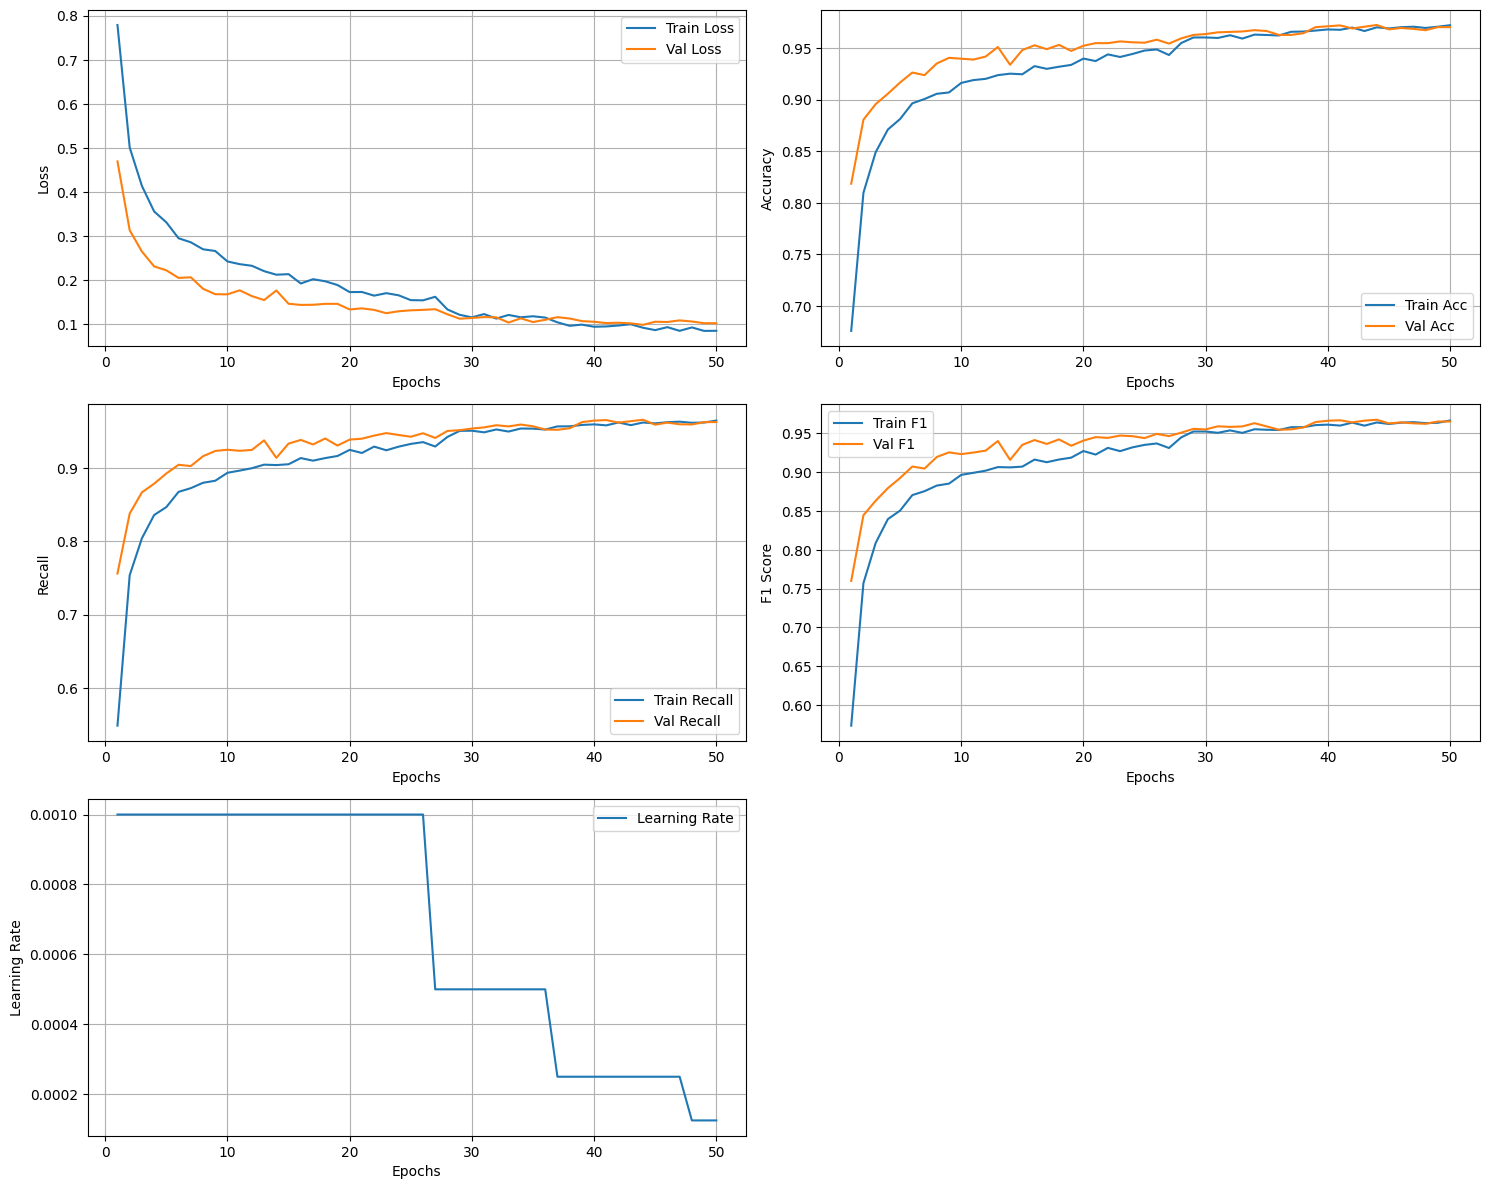

Time taken: 00:09:00.33


In [5]:
start = time.time()

dataset_path = '../../data/datasets/action_images_dataset_v1.0'

num_epochs = 50
num_classes = 4
batch_size = 32
learning_rate = 0.001
val_size = 0.2
test_size = 0.1
seed = 42

model, loaders, class_names = train_net(
    num_epochs=num_epochs, 
    dataset_path=dataset_path, 
    num_classes=num_classes, 
    batch_size=batch_size, 
    lr=learning_rate,
    val_size=val_size,
    test_size=test_size,
    random_state=seed
)

end = time.time()
print_time_taken(start, end)

# Pokretanje na test skupu i komentar

**Kao i u prethodnoj svesci gde je treniran CNN na "lošim" podacima, možemo primetiti da za razliku od ostalih modela CNN daje ozbiljno dobre rezultate na test skupu ako gledamo njihovu sličnost sa rezultatima na trening, odnosno validacionom skupu. Vrednosti posmatranih metrika su maltene identične. Ovo smo se i nadali da ćemo postići, tj. da će se CNN-ovi pokazati kao dobri generalizatori.**

Test accuracy: 0.9631
Test precision: 0.9547
Test recall: 0.9596
Test F1 score: 0.9571

Classification report:
              precision    recall  f1-score   support

    backhand       0.93      0.92      0.92       190
    forehand       0.94      0.94      0.94       230
       other       0.98      0.97      0.98       615
       serve       0.98      1.00      0.99       159

    accuracy                           0.96      1194
   macro avg       0.95      0.96      0.96      1194
weighted avg       0.96      0.96      0.96      1194



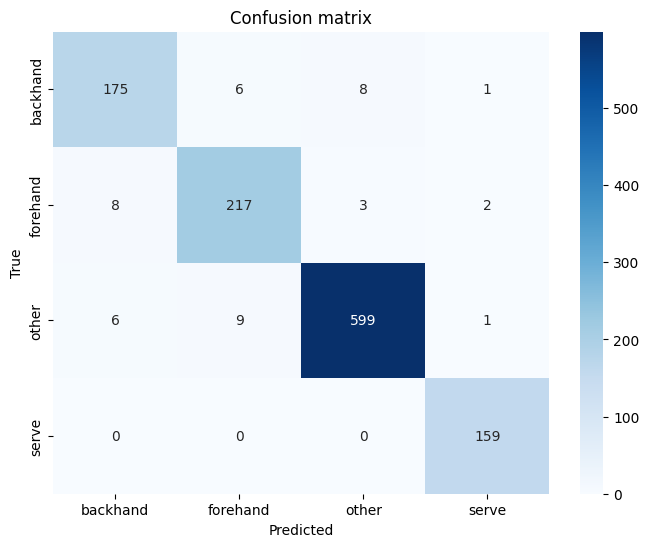

In [6]:
model.eval()

all_preds_test = []
all_labels_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels_test, all_preds_test)
test_prec = precision_score(all_labels_test, all_preds_test, average='macro')
test_recall = recall_score(all_labels_test, all_preds_test, average='macro')
test_f1 = f1_score(all_labels_test, all_preds_test, average='macro')

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test precision: {test_prec:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test F1 score: {test_f1:.4f}")

print("\nClassification report:")
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

cm = confusion_matrix(all_labels_test, all_preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
torch.save(model.state_dict(), '../../models/08_cnn_relabeled_data_50ep.pth')
torch.save(model, '../../models/08_cnn_relabeled_data_50ep_full.pth')